In [141]:
import torch
from load_data import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [142]:
device = torch.device('cuda:0')

In [143]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_lsac_data(random_state=42)
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

In [144]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training default: ", sum(ytr==0)/len(ytr))
print("test default: ", sum(yte==0)/len(yte))
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)
print('# output vars', ytr.shape)

sensitive ratio:  [0.56174334]
training default:  [0.19860102]
test default:  [0.19984936]
# training samples: (18585, 9)
# test samples: (7966, 9)
# sensitive vars (18585, 1)
# output vars (18585, 1)


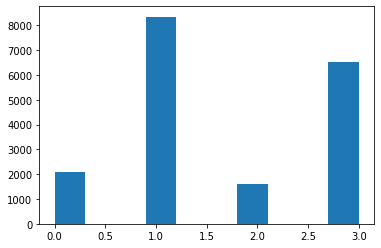

In [145]:
yz_tr = ytr+Ztr*2
plt.hist(yz_tr)
plt.show()

In [146]:
N1 = 10000
Xtr1, ytr1, Ztr1, Xtr2, ytr2, Ztr2 = split_initial_dataset(Xtr,ytr,Ztr,N_init=N1,random_state=42)

In [147]:
print("sensitive ratio: ",sum(Ztr==0)/len(Ztr))
print("training init: ", sum(ytr1==0)/len(ytr1))
print("select init: ", sum(ytr2==0)/len(ytr2))
print("test default: ", sum(yte==0)/len(yte))

sensitive ratio:  [0.56174334]
training init:  [0.1987]
select init:  [0.19848573]
test default:  [0.19984936]


In [148]:
from fairNN_train import *
from load_data import *
from fair_eval import *

In [149]:
class Args:
    def __init__(self):
        self.epochs = 20
#         self.max_epochs = None
        self.AL_iters = 10 # AL batch 몇 번 뽑는지?
        self.AL_batch = 32 # AL 시에 select 되는 데이터 수
        self.batch_size = 64
        self.AL_select = 'acc'
        self.num_classes = 2
#         self.AL_valid = 32
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [150]:
from fairAL_utils import *

In [151]:
args = Args()
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=False)
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [152]:
n_features = train_data.tensors[0].shape[1]
clf = Classifier(n_features=n_features)
clf.to(device)

Classifier(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [153]:
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())
liveloss = PlotLosses()

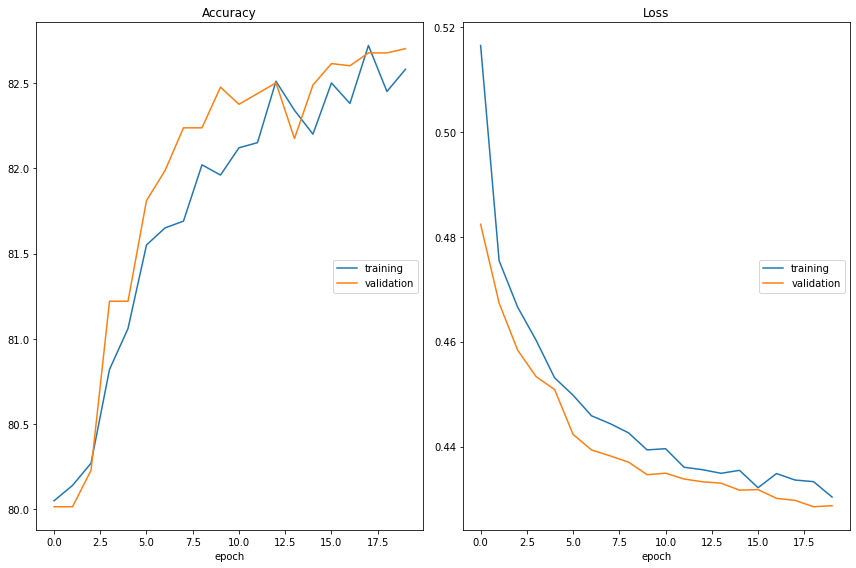

Accuracy
	training         	 (min:   80.050, max:   82.720, cur:   82.580)
	validation       	 (min:   80.015, max:   82.701, cur:   82.701)
Loss
	training         	 (min:    0.430, max:    0.516, cur:    0.430)
	validation       	 (min:    0.429, max:    0.482, cur:    0.429)
Finished Training


In [154]:
train_model(clf, train_loader, clf_criterion,clf_optimizer, device, args.epochs, test_loader,liveloss)
torch.save(clf.state_dict(),"../results/lsac/AL_iter_1.ckpt") # 모든 애들을 다 0으로 예측함

In [17]:
clf.load_state_dict(torch.load("../results/bank/AL_iter_0.ckpt"))

<All keys matched successfully>

# Visualize the trained model

In [156]:
clf.eval()
from torchsummary import summary
summary(clf.to('cuda:0'),(9,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             320
              ReLU-2                   [-1, 32]               0
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 32]           1,056
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                   [-1, 32]           1,056
              ReLU-8                   [-1, 32]               0
           Dropout-9                   [-1, 32]               0
           Linear-10                    [-1, 1]              33
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total

In [157]:
param_names = ['lin1_w','lin1_b','lin2_w, lin2_b','lin3_w','lin3_b','lin4_w','lin4_b']

In [158]:
import autograd_hacks
import random
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# for i, pram in enumerate(clf.modules()):
#     print(i,pram.__class__.__name__)

# instance-level gradient

In [161]:
def auto_grad_compute(clf,x,y,criterion,device):
    clf.to(device).eval()
    x,y = x.to(device),y.to(device)
    autograd_hacks.add_hooks(clf)
    clf.zero_grad()
    clear_backprops(clf)
    out = clf(x)
    
    count_backprops(clf)
    criterion(out,y).backward()
    remove_backprops(clf)
    autograd_hacks.compute_grad1(clf)
    
    tmp=[]
    for k, param in enumerate(clf.parameters()):
        tmp.append(param.grad1.reshape(x.size(0),-1).detach().cpu())
    grad_t = torch.cat(tmp,dim=1).detach().cpu()
    return tmp, grad_t


In [162]:
grad_dic = {}
for pn in param_names:
    grad_dic[pn]=[]
wgrad_list = []
y_list = []
z_list = []
out_list = []

for i, (x,y,z) in enumerate(train_loader):
#     if i>1:
#         break
    tmp,grt = auto_grad_compute(clf,x,y,clf_criterion,device)
    clf.to(device)
    out_list.append(clf(x.to(device)).detach().cpu())
    for j,pn in enumerate(param_names):
        grad_dic[pn].append(tmp[j])
    wgrad_list.append(grt)
    y_list.append(y.detach().cpu().numpy())
    z_list.append(z.detach().cpu().numpy())

out_arr = np.array(torch.cat(out_list,axis=0).numpy()>0.5,dtype=np.float32).flatten()
y_arr = np.concatenate(y_list).flatten()
z_arr = np.concatenate(z_list).flatten()    

In [87]:
grad_dic2 = {}
for pn in param_names:
    grad_dic2[pn]=[]
wgrad_list2 = []
y_list2 = []
z_list2 = []

for i, (x,y,z) in enumerate(test_loader):
#     if i>1:
#         break
    tmp,grt = auto_grad_compute(clf,x,y,clf_criterion,device)
    for j,pn in enumerate(param_names):
        grad_dic2[pn].append(tmp[j])
    wgrad_list2.append(grt)
    y_list2.append(y.detach().cpu().numpy())
    z_list2.append(z.detach().cpu().numpy())

y_arr2 = np.concatenate(y_list2).flatten()
z_arr2 = np.concatenate(z_list2).flatten()    

In [163]:
wgrad_arr = np.array(torch.cat(wgrad_list,dim=0).numpy(),dtype=np.float32)

In [164]:
wmean = np.mean(wgrad_arr,axis=0)
wmean_y0 = np.mean(wgrad_arr[y_arr==0],axis=0)
wmean_y1 = np.mean(wgrad_arr[y_arr==1],axis=0)

wmean_z0 = np.mean(wgrad_arr[z_arr==0],axis=0)
wmean_z1 = np.mean(wgrad_arr[z_arr==1],axis=0)

In [165]:
aa = [wmean,wmean_y0,wmean_y1,wmean_z0,wmean_z1]
for a in aa:
    print(np.linalg.norm(a))

0.13962102
4.8208594
1.0861616
0.21773386
0.09296312


In [170]:
from sklearn.metrics.pairwise import cosine_similarity
aan = np.row_stack(aa)
print(cosine_similarity(aan,aan))

[[ 1.0000001   0.671366   -0.57849014  0.96020055  0.5429791 ]
 [ 0.671366    1.0000004  -0.992907    0.8454311  -0.23911381]
 [-0.57849014 -0.992907    0.9999998  -0.7764525   0.3502759 ]
 [ 0.96020055  0.8454311  -0.7764525   1.0000006   0.2868148 ]
 [ 0.5429791  -0.23911381  0.3502759   0.2868148   0.9999997 ]]


In [167]:
calculate_overall_accuracy(out_arr,y_arr)

0.8285

In [168]:
calculate_overall_accuracy(out_arr[z_arr==0],y_arr[z_arr==0])

0.824052659669098

In [169]:
calculate_overall_accuracy(out_arr[z_arr==1],y_arr[z_arr==1])

0.8342087234528431

In [132]:
def calculate_overall_accuracy(pred,y):
    pred = pred.flatten()
    return np.sum(pred==y)/len(pred)

In [177]:
gdl_arr = torch.cat(grad_dic['lin4_w'],dim=0).numpy()
print(gdl_arr.shape)

(10000, 32)


In [178]:
lmean = np.mean(gdl_arr,axis=0)
lmean_y0 = np.mean(gdl_arr[y_arr==0],axis=0)
lmean_y1 = np.mean(gdl_arr[y_arr==1],axis=0)

lmean_z0 = np.mean(gdl_arr[z_arr==0],axis=0)
lmean_z1 = np.mean(gdl_arr[z_arr==1],axis=0)

In [179]:
from sklearn.metrics.pairwise import cosine_similarity
aal = [lmean,lmean_y0,lmean_y1,lmean_z0,lmean_z1]
for a in aal:
    print(np.linalg.norm(a))

aanl = np.row_stack(aal)
print(cosine_similarity(aanl,aanl))

0.0093537625
0.5467532
0.12926793
0.016414464
0.010477241
[[ 1.          0.5711562  -0.5087406   0.87814206  0.27278316]
 [ 0.5711562   1.         -0.99724925  0.8935682  -0.63254535]
 [-0.5087406  -0.99724925  1.0000002  -0.85789883  0.68806326]
 [ 0.87814206  0.8935682  -0.85789883  0.99999994 -0.22071445]
 [ 0.27278316 -0.63254535  0.68806326 -0.22071445  1.        ]]


In [182]:
type(grad_dic) == dict

True

In [71]:
y_arr2.shape

(13564,)

## visualize

In [171]:
from sklearn.manifold import TSNE

In [172]:
from sklearn.decomposition import PCA

def viz_plot_grad(grad_list, c_idx = None,method='pca',lywise=False,metric='euclidean',param_names = None):
    if lywise:
        print("lywise")
        assert param_names is not None
        for i, pn in enumerate(param_names):
#             print(grad_list[pn])
            grad_arr = np.array(torch.cat(grad_list[pn],dim=0).numpy(),dtype=np.float32)
            draw_plot(grad_arr,c_idx,method,metric,title=pn)
    else:
        grad_arr = np.array(torch.cat(grad_list,dim=0).numpy(),dtype=np.float32)
#         print(grad_arr.shape)
        draw_plot(grad_arr,c_idx,method,metric)

def draw_plot(grad_arr, c_idx, method,metric = 'euclidean',title =None):
    assert method in ['pca','tsne']
    if method == 'pca':
        grad_emb = PCA(n_components=2,whiten=False).fit_transform(grad_arr)
    else:
        grad_emb = TSNE(n_components=2,learning_rate='auto',init = 'random',metric=metric).fit_transform(grad_arr)
    fig,ax = plt.subplots()
    scatter = ax.scatter(grad_emb[:,0],grad_emb[:,1],c=c_idx)
    legend1 = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend1)
    if title is not None:
        plt.title(title)
    plt.show()

In [105]:
len(wgrad_list)

157

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


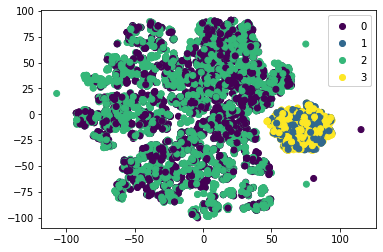

In [111]:
viz_plot_grad(wgrad_list,y_arr+2*z_arr,method='tsne',metric='cosine')

(13564, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


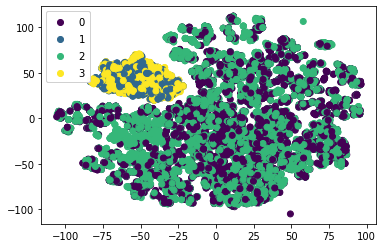

In [112]:
viz_plot_grad(wgrad_list2,y_arr2+2*z_arr2,method='tsne',metric='cosine')

(10000, 3617)


/home/srp/.pyenv/versions/pytorch15/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


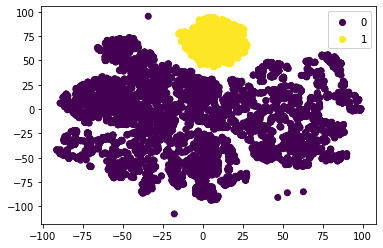

In [109]:
viz_plot_grad(wgrad_list,y_arr,method='tsne',metric='cosine')

(10000, 3617)


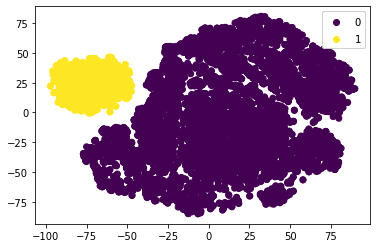

In [107]:
viz_plot_grad(wgrad_list,y_arr,method='tsne')

lywise


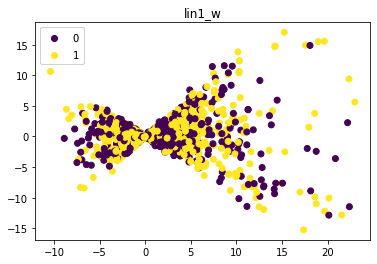

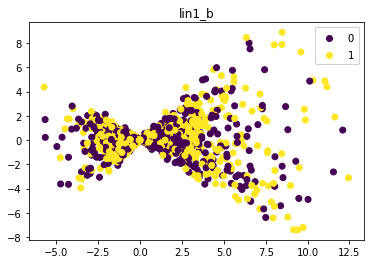

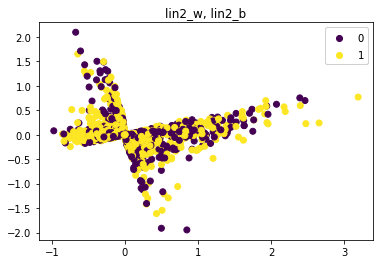

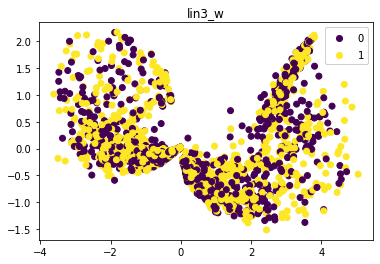

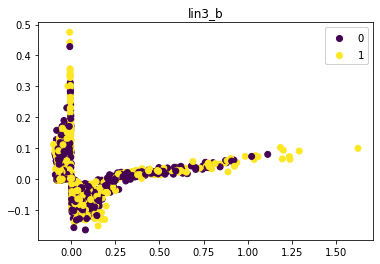

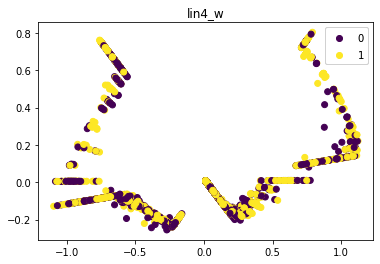

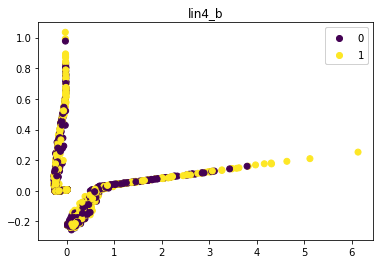

In [95]:
viz_plot_grad(grad_dic,z_arr,lywise=True,param_names =param_names)

lywise


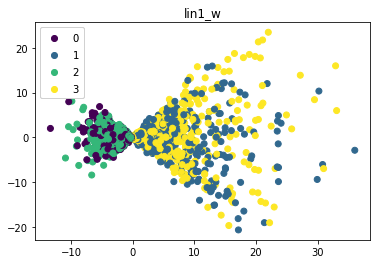

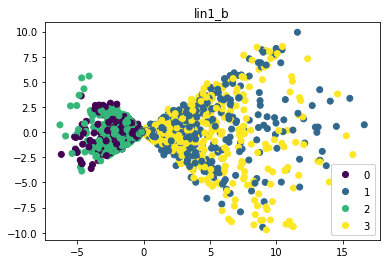

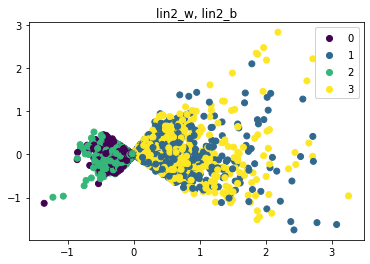

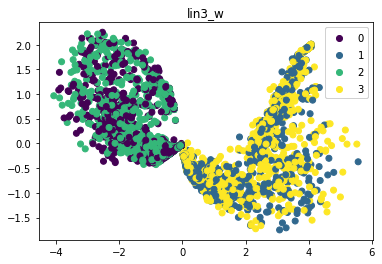

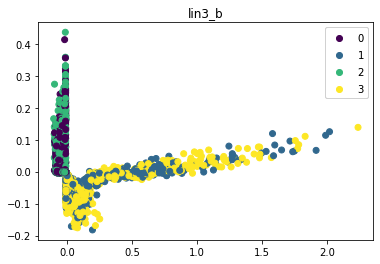

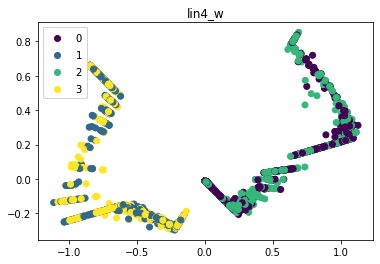

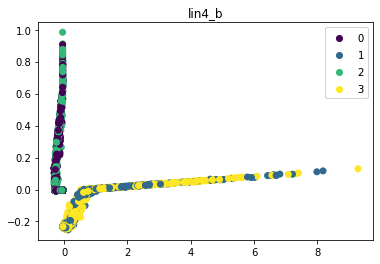

In [113]:
viz_plot_grad(grad_dic2,y_arr2+2*z_arr2,lywise=True,param_names =param_names)

lywise


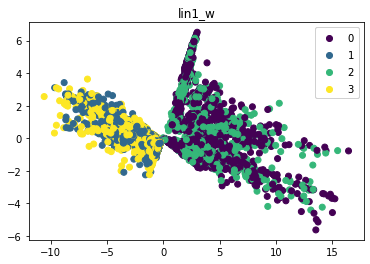

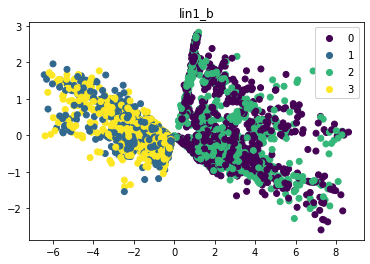

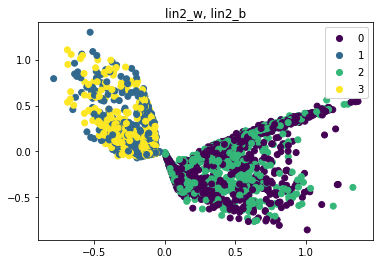

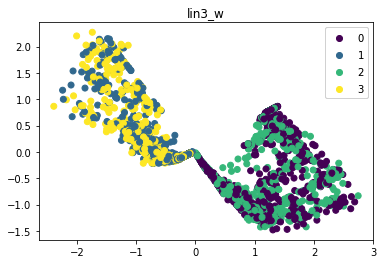

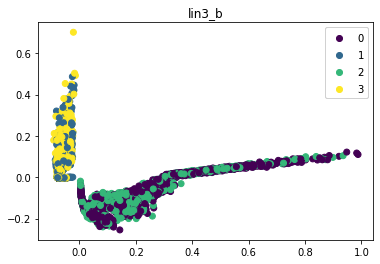

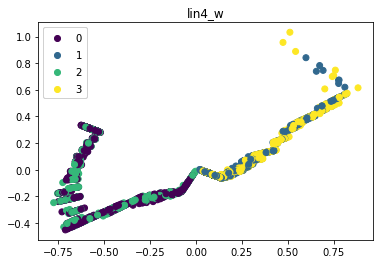

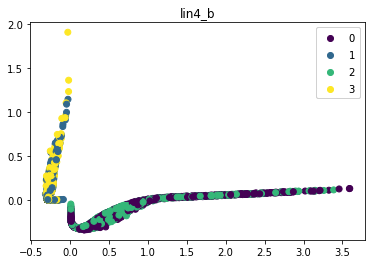

In [174]:
viz_plot_grad(grad_dic,y_arr+2*z_arr,lywise=True,param_names =param_names)